# Framework for prototyping

There are innumerable strategies for implementing machine learning systems, and there is by no means a single correct approach. For our purposes, we seek an approach that is easy for *prototyping* new techniques. This means that we would like to minimize the time it takes for an idea to go from the drawing board to working software. Debugging should thus be as easy as possible, even at the cost of time/memory requirements when deployed (Python typically allows us to realize a good balance). That said, testing prototypes often requires a lot of systematic modification of parameters, and thus whenever possible, running independent tests in parallel can save a tremendous amount of time.

Our approach centers on three objects: __data__, __models__, and __algorithms__. Their characteristics are as follows:

- __Data object:__ This is a class object which is used to store the data used for training, validation, and testing as necessary.
- __Model object:__ This is a class object which implements functions which take both data objects and algorithm states as arguments. These functions are used for both training and evaluation.
- __Algorithm object:__ This is an iterator (class) object which maintains a "state" characterized by, e.g., a parameter vector, a cumulative tally of the resources used thus far, and so forth. At each iterative update, the algorithm calls methods which take both data and model objects as arguments.

__Contents:__

- <a href="#getstarted">Getting started with data and model objects</a>

- <a href="#trivial">Implementing a trivial algorithm</a>

- <a href="#link3">Linking up the data-model-algorithm trio</a>

- <a href="#learning">Optimization and learning</a>

___

<a id="getstarted"></a>
## Getting started with data and model objects

Let's begin with an extremely simple example to motivate our work moving forward. Consider the linear model

\begin{align*}
y = \langle w^{\ast}, x \rangle + \varepsilon, \quad \mathbf{E}\varepsilon = 0, \mathbf{E}\varepsilon^2 < \infty, x \in \mathbb{R}^d
\end{align*}

Given examples $(x_1, y_1),\ldots,(x_n, y_n)$, we would like to infer a $\widehat{w}$ such that $\langle \widehat{w}, x \rangle \approx y$ is a good approximation for an as-yet unobserved pair $(x,y)$. Obviously, the first thing we will need to do is store these observations. Let's prepare a `DataSet` object as a simple base class.

In [1]:
import numpy as np

In [2]:
class DataSet:
    '''
    Base class for data objects.
    '''
    
    def __init__(self, paras=None):
        self.X_tr = None
        self.X_te = None
        self.y_tr = None
        self.y_te = None
        self.paras = paras
    
    def init_tr(self, X, y):
        self.X_tr = X
        self.y_tr = y
        self.n_tr = X.shape[0]
        
    def init_te(self, X, y):
        self.X_te = X
        self.y_te = y
        self.n_te = X.shape[0]

The learning task at hand is one of *regression*, in particular using a linear model. Starting at the highest conceptual level, let's make the following simple requirements on our `Model` base case:

- `Model` objects should implement *loss* functions for training and/or evaluation, and when relevant, gradient information for those losses.

With this simple requirement, we can establish the base class for model objects.

In [3]:
class Model:
    '''
    Base class for model objects.
    '''

    def __init__(self, name=None):
        self.name = name

    def l_imp(self, w=None, X=None, y=None, lamreg=None):
        raise NotImplementedError
    
    def l_tr(self, w, data, n_idx=None, lamreg=None):
        if n_idx is None:
            return self.l_imp(w=w, X=data.X_tr,
                              y=data.y_tr,
                              lamreg=lamreg)
        else:
            return self.l_imp(w=w, X=data.X_tr[n_idx,:],
                              y=data.y_tr[n_idx,:],
                              lamreg=lamreg)
    
    def l_te(self, w, data, n_idx=None, lamreg=None):
        if n_idx is None:
            return self.l_imp(w=w, X=data.X_te,
                              y=data.y_te,
                              lamreg=lamreg)
        else:
            return self.l_imp(w=w, X=data.X_te[n_idx,:],
                              y=data.y_te[n_idx,:],
                              lamreg=lamreg)

    def g_imp(self, w=None, X=None, y=None, lamreg=None):
        raise NotImplementedError
    
    def g_tr(self, w, data, n_idx=None, lamreg=None):
        if n_idx is None:
            return self.g_imp(w=w, X=data.X_tr,
                              y=data.y_tr,
                              lamreg=lamreg)
        else:
            return self.g_imp(w=w, X=data.X_tr[n_idx,:],
                              y=data.y_tr[n_idx,:],
                              lamreg=lamreg)
    
    def g_te(self, w, data, n_idx=None, lamreg=None):
        if n_idx is None:
            return self.g_imp(w=w, X=data.X_te,
                              y=data.y_te,
                              lamreg=lamreg)
        else:
            return self.g_imp(w=w, X=data.X_te[n_idx,:],
                              y=data.y_te[n_idx,:],
                              lamreg=lamreg)

Note that the loss-related methods of `Model` objects have argument `data` which is naturally assumed to be of `DataSet` form. The argument `w` is left general: in most cases this will be a Numpy array, but it could easily be a function or some other object. Note the `n_idx` argument, which is optional, lets us specify subsets.

To actually implement a regression model requires us to fill in the details of the loss and gradient (if applicable). Which loss we use is up to us. As a simple and concrete example, let's assume that our learning algorithm will be "least squares linear regression". This means `w` corresponds to a vector $w \in \mathbb{R}^d$ determining a linear map. The "least" part means that we will (eventually) be minimizing a sum of squared errors, namely

\begin{align*}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum_{i=1}^{n} (\langle w, x_i \rangle - y_i)^2 \to \hat{w}.
\end{align*}

For this optimization, of course we must compute the error and/or its gradient with respect to $w$. In our model object, we will require:

- `l_imp`: computes $(y - \langle w, x \rangle)^2 / 2$ for each pair $(x,y)$.
- `g_imp`: computes $(y - \langle w, x \rangle)(-1)x \in \mathbb{R}^d$ for each pair $(x,y)$.

It is difficult to imagine a simpler model to implement; it takes the form of `LinearL2`, a sub-class of `LinReg`, both given below.

In [4]:
class LinReg(Model):
    '''
    General-purpose linear regression model.
    No losses are implemented, just a predict()
    method.
    '''
    
    def __init__(self, data=None, name=None):
        super(LinReg, self).__init__(name=name)
        pass

    def predict(self, w, X):
        '''
        Predict real-valued response.
        w is a (d x 1) array of weights.
        X is a (k x d) matrix of k observations.
        Returns array of shape (k x 1) of predicted values.
        '''
        return X.dot(w)


class LinearL2(LinReg):
    '''
    An orthodox linear regression model
    using the l2 error; typically this
    will be used for the classical least
    squares regression.
    '''
    
    def __init__(self, data=None):
        super(LinearL2, self).__init__(data=data)

        
    def l_imp(self, w, X, y, lamreg=None):
        '''
        Implementation of l2-loss under linear model
        for regression.

        Input:
        w is a (d x 1) matrix of weights.
        X is a (k x numfeat) matrix of k observations.
        y is a (k x 1) matrix of labels in {-1,1}.
        lamreg is a regularization parameter (l2 penalty).

        Output:
        A vector of length k with losses evaluated at k points.
        '''
        if lamreg is None:
            return (y-self.predict(w=w,X=X))**2/2
        else:
            penalty = lamreg * np.linalg.norm(w)**2
            return (y-self.predict(w=w,X=X))**2/2 + penalty
    
    
    def g_imp(self, w, X, y, lamreg=None):
        '''
        Implementation of the gradient of the l2-loss
        under a linear regression model.

        Input:
        w is a (d x 1) matrix of weights.
        X is a (k x numfeat) matrix of k observations.
        y is a (k x 1) matrix of labels in {-1,1}.

        Output:
        A (k x numfeat) matrix of gradients evaluated
        at k points.
        '''
        if lamreg is None:
            return (y-self.predict(w=w,X=X))*(-1)*X
        else:
            penalty = lamreg*2*w.T
            return (y-self.predict(w=w,X=X))*(-1)*X + penalty

With these three objects, we have organized everything that needs to be passed to learning algorithms. Without a good learning algorithm, there is not much that we can do. Just as an illustration, we do some computations below.

In [5]:
# Prepare simulated data.
d = 5
n_tr = 100
n_te = 100
w_star = np.arange(d).reshape((d,1)) + 1.0

X_tr = np.random.normal(size=(n_tr,d))
noise_tr = np.random.normal(size=(n_tr,1))
y_tr = X_tr.dot(w_star) + noise_tr

X_te = np.random.normal(size=(n_te,d))
noise_te = np.random.normal(size=(n_te,1))
y_te = X_te.dot(w_star) + noise_te

# Prepare data object.
data = DataSet()
data.init_tr(X=X_tr, y=y_tr)
data.init_te(X=X_te, y=y_te)

# Prepare model object.
mod = LinearL2()

# Prepare random initial value, and take closer to solution.
w_init = np.random.uniform(low=-5.0, high=5.0, size=(d,1))
weight_balance = np.linspace(0.0, 1.0, 5)
print("===============")
for wt in weight_balance:
    w_est = wt * w_star + (1-wt) * w_init
    print("l_tr:", np.mean(mod.l_tr(w_est, data=data)),
          "l_te:", np.mean(mod.l_te(w_est, data=data)))
    print("g_tr:\n", np.mean(mod.g_tr(w_est, data=data), axis=0))
    print("g_te:\n", np.mean(mod.g_te(w_est, data=data), axis=0))
    print("===============")

l_tr: 43.210858600395134 l_te: 34.72571810061989
g_tr:
 [-1.0842935  -5.69836324 -6.56033462 -4.21325835 -2.03863264]
g_te:
 [ 0.81162686 -4.54165655 -4.35494854 -3.80724044 -3.13335283]
l_tr: 24.62376824373061 l_te: 19.66021401085465
g_tr:
 [-0.81138917 -4.27660892 -4.93786732 -3.15201289 -1.51993492]
g_te:
 [ 0.60915185 -3.43434172 -3.17889841 -2.89195522 -2.39161763]
l_tr: 11.33036757090696 l_te: 8.929317872500317
g_tr:
 [-0.53848483 -2.8548546  -3.31540002 -2.09076743 -1.00123721]
g_te:
 [ 0.40667685 -2.3270269  -2.00284828 -1.97667    -1.64988243]
l_tr: 3.3306565819241754 l_te: 2.5330296855568974
g_tr:
 [-0.2655805  -1.43310028 -1.69293271 -1.02952197 -0.48253949]
g_te:
 [ 0.20420185 -1.21971207 -0.82679816 -1.06138477 -0.90814722]
l_tr: 0.624635276782252 l_te: 0.47134945002438833
g_tr:
 [ 0.00732384 -0.01134595 -0.07046541  0.03172349  0.03615823]
g_te:
 [ 0.00172684 -0.11239725  0.34925197 -0.14609955 -0.16641202]


One can clearly see that getting closer to $w^{\ast}$ results in smaller loss values, and a flatter gradient. Before we dig into any more interesting models, let's cover the basics of implementing learning algorithms.

<a id="trivial"></a>
## Implementing a trivial algorithm

As a very simple initial example, let's consider an algorithm that does nothing special at all, but manages its own state and the number of iterations.

In [6]:
class Algo_trivial:
    '''
    An iterator which does nothing special at all, but makes
    a trivial update to the initial parameters given, and
    keeps record of the number of iterations made.
    '''

    def __init__(self, w_init, t_max):
        
        self.w = np.copy(w_init)
        self.t_max = t_max


    def __iter__(self):

        self.t = 0
        print("(__iter__): t =", self.t)

        return self
    

    def __next__(self):
        
        # Condition for stopping.
        if self.t >= self.t_max:
            print("--- Condition reached! ---")
            raise StopIteration

        print("(__next__): t =", self.t)
        self.w += 5
        self.t += 1
        # Note: __next__ does not need to return anything.
        

    def __str__(self):

        out = "State of w:" + "\n" + "  " + str(self.w)
        return out


Let's observe how it behaves.

In [7]:

import numpy as np

al = Algo_trivial(w_init=np.array([1,2,3,4,5]), t_max=10)

print("Printing docstring:")
print(al.__doc__) # check the docstring

for onestep in al:
    pass # do nothing special


Printing docstring:

    An iterator which does nothing special at all, but makes
    a trivial update to the initial parameters given, and
    keeps record of the number of iterations made.
    
(__iter__): t = 0
(__next__): t = 0
(__next__): t = 1
(__next__): t = 2
(__next__): t = 3
(__next__): t = 4
(__next__): t = 5
(__next__): t = 6
(__next__): t = 7
(__next__): t = 8
(__next__): t = 9
--- Condition reached! ---


Key points:

 - After the `StopIteration` exception is raised, immediately exit the for loop.
 - At the "zeroth" step, both `iter` and `next` are called.

Note above that the `for` loop is just doing the following operations for us.

In [8]:
iter(al)
next(al)
next(al)
next(al)
next(al) # and so on...

(__iter__): t = 0
(__next__): t = 0
(__next__): t = 1
(__next__): t = 2
(__next__): t = 3


In [9]:
al = Algo_trivial(w_init=np.array([1,2,3,4,5]), t_max=10)

for onestep in al:
    print(al) # useful for monitoring state.

print("One last check after exiting:")
print(al) # ensure that no additional changes were made.

(__iter__): t = 0
(__next__): t = 0
State of w:
  [ 6  7  8  9 10]
(__next__): t = 1
State of w:
  [11 12 13 14 15]
(__next__): t = 2
State of w:
  [16 17 18 19 20]
(__next__): t = 3
State of w:
  [21 22 23 24 25]
(__next__): t = 4
State of w:
  [26 27 28 29 30]
(__next__): t = 5
State of w:
  [31 32 33 34 35]
(__next__): t = 6
State of w:
  [36 37 38 39 40]
(__next__): t = 7
State of w:
  [41 42 43 44 45]
(__next__): t = 8
State of w:
  [46 47 48 49 50]
(__next__): t = 9
State of w:
  [51 52 53 54 55]
--- Condition reached! ---
One last check after exiting:
State of w:
  [51 52 53 54 55]


__Exercises:__

0. How is `w` modified by `Algo_trivial` every iteration? We call this "trivial" since the algorithm in no way depends on any data inputs, it is simply a hard-coded rule.

0. Modify `Algo_trivial` such that the elements of `w` are doubled at each iteration.

0. Furthermore, modify the parameters passed to `al` such that we start at $w=(0,1,2,3,4)$ and end when $w=(0, 16, 32, 48, 64) = (0 \times 2^4, 1 \times 2^4, 2 \times 2^4, 3 \times 2^4, 4 \times 2^4)$.

0. What happens to the state of `w` if you run the `for` loop multiple times without re-initializing `al` each time?


<a id="link3"></a>
## Linking up the data-model-algorithm trio

Let us return to our linear regression example; a non-trivial algorithm which actually "learns" must inevitably depend on data. Let us use a *steepest descent* implementation of the *empirical risk minimization* (ERM) learning strategy. Important facts are summarized below:

- Data: Inputs and responses, $x \in \mathbb{R}^{d}$, $y \in \mathbb{R}$. Data set is $\{(x_{1},y_{1}),\ldots,(x_{n},y_{n})\}$.

- Model: Linear regression, with squared error. Assume $y = \langle w^{\ast}, x\rangle + \varepsilon$ as underlying model. Loss is $L(w;x,y) = (y - \langle w, x\rangle)^{2}/2$, with gradient $\nabla L(w;x,y) = -(y-\langle w, x\rangle)x$.

- Algorithm: steepest descent routine with step size $\alpha > 0$. Writing $z_{i}=(x_{i},y_{i})$, this is

\begin{align*}
w_{(t+1)} \gets w_{(t)} - \alpha \frac{1}{n} \sum_{i=1}^{n}\nabla L(w_{(t)}; z_{i}).
\end{align*}

Very simple. We've already covered the data and model parts, and we have the machinery to implement the algorithm. This is done below in `Algo_SimpleGD`.

In [10]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [11]:

class Algo_SimpleGD:
    '''
    Iterator which implements a line-search steepest descent method,
    using the sample mean estimate of the gradient.
    '''
    
    def __init__(self, w_init, t_max, step, store):
        self.w = w_init
        self.t = None
        self.t_max = t_max
        self.step = step
        self.store = store
        
        # Keep record of all updates (optional).
        if self.store:
            self.wstore = np.zeros((self.w.size,t_max+1), dtype=np.float32)
            self.wstore[:,0] = self.w.flatten()
        else:
            self.wstore = None
        
    def __iter__(self):
        self.t = 0
        return self
        
    def __next__(self):
        if self.t >= self.t_max:
            raise StopIteration
        
    def newdir(self, model, data):
        return (-1) * np.mean(model.g_tr(w=self.w, data=data), axis=0, keepdims=True)

    def update(self, model, data):
        
        # Parameter update.
        stepsize = self.step(self.t)
        newdir = self.newdir(model=model, data=data)
        self.w = self.w + stepsize * np.transpose(newdir)
        
        # Monitor update.
        self.t += 1
        
        # Keep record of all updates (optional).
        if self.store:
            self.wstore[:,self.t] = self.w.flatten()


Some key points to keep in mind:

- `w_init` corresponds to $w_{(0)}$, the initial value. Must be provided at initialization.
- `newdir` returns the update direction.
- `step` is a callback function for controlling the step size as a function of step number `t`, which determines how far to move in the prescribed direction.
- `update` actually carries out the parameter update, as well as the "monitor" update of time elapsed.


Let us now generate some random data, and put these new classes to work.

In [12]:
# Generate data.
data = DataSet()
n = 100
d = 2
w_star = math.pi * np.ones((d,1), dtype=np.float32)
X = np.random.standard_normal(size=(n*2,d))
epsilon = np.random.standard_t(df=3, size=(n*2,1))
y = X.dot(w_star) + epsilon
data.init_tr(X=X[0:n,:], y=y[0:n,:]) # former half for training
data.init_te(X=X[n:,:], y=y[n:,:]) # latter half for testing

print("X_tr:", data.X_tr.shape, "... sumcheck =", np.sum(data.X_tr))
print("y_tr:", data.y_tr.shape, "... sumcheck =", np.sum(data.y_tr))
print("X_te:", data.X_te.shape, "... sumcheck =", np.sum(data.X_te))
print("y_te:", data.y_te.shape, "... sumcheck =", np.sum(data.y_te))

X_tr: (100, 2) ... sumcheck = -9.94677583241537
y_tr: (100, 1) ... sumcheck = -40.20352170786684
X_te: (100, 2) ... sumcheck = -1.089890767972685
y_te: (100, 1) ... sumcheck = 16.95676631804479


In [13]:
# Initialize model.
mod = LinearL2()

In [14]:
# Initialize learning algorithm.

w_init = np.random.uniform(size=(d,1))

def alpha_fixed(t, val):
    return val

def make_step(u):
    def mystep(t):
        return alpha_fixed(t=t, val=u)
    return mystep

al = Algo_SimpleGD(w_init=w_init,
                   t_max=15,
                   step=make_step(0.15),
                   store=True)

In [15]:
# Iterate the learning algorithm.
for onestep in al:
    al.update(model=mod, data=data)

print("State of algorithm after completion:")
print("t =", al.t)
print("w =", al.w)

State of algorithm after completion:
t = 15
w = [[2.97596384]
 [2.74678402]]


Now, as a reference, we recall the familiar fact that the sum of squared errors under a linear model has a closed-form solution, i.e., it can be computed exactly, given the data, instead of relying on an iterative approximation. Let's compute the OLS solution, written `w_OLS`, and look at how our algorithm's output compares.

In [16]:
w_OLS = np.linalg.lstsq(a=data.X_tr, b=data.y_tr, rcond=None)[0]

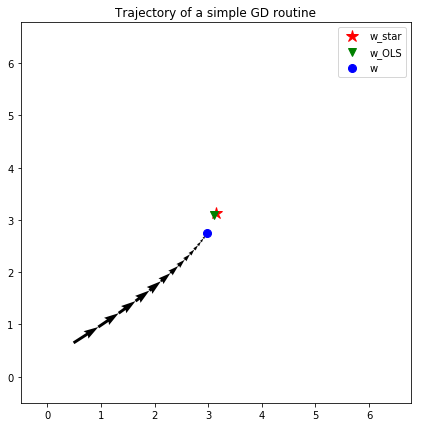

In [17]:
# Visualize the output (in 2D case).
mypath = al.wstore

if (d == 2):

    init_diff = np.linalg.norm(w_star-w_init) * 1.0
    
    myfig = plt.figure(figsize=(7,7))
    ax = myfig.add_subplot(1,1,1)
    
    ax.quiver(mypath[0,:-1], mypath[1,:-1],
              mypath[0,1:]-mypath[0,:-1],
              mypath[1,1:]-mypath[1,:-1],
              scale_units='xy', angles='xy', scale=1, color='k')
    
    ax.plot(*w_star, 'r*', markersize=12, label="w_star") # print true value.
    ax.plot(*w_OLS, 'gv', markersize=8, label="w_OLS") # print OLS estimate.
    ax.plot(*mypath[:,-1], 'bo', markersize=8, label="w") # print our final estimate.
    ax.legend(loc=1,ncol=1)
    plt.title('Trajectory of a simple GD routine')
    plt.xlim((w_star[0]-init_diff, w_star[0]+init_diff))
    plt.ylim((w_star[1]-init_diff, w_star[1]+init_diff))
    plt.show()

__Exercises:__

0. Fixing the algorithm settings, try modifying the sample size, noise distribution. Describe how this impacts the search trajectory.

0. Fixing the data distribution settings, try modifying the algorithm settings such as the step size, number of iterations, and initial value. Describe how this impacts the search trajectory.

<a id="learning"></a>
## Optimization and learning

For readers unfamiliar with machine learning, a natural question may arise: *what is the difference between optimization and learning?*

In doing optimization, we are trying to find values, often under some constraints, that minimize particular functions of interest. From an engineering perspective, it usually only makes sense to consider functions that we can actually *observe*. That is, if we want to minimize $f(\cdot)$, and we have some candidate $\widehat{x}$, we would like to be able to compute $f(\widehat{x})$ in order to verify that indeed $f(\widehat{x}) \leq f(x)$ for all $x$. Assuming $f$ has partial derivatives, first-order methods (like gradient descent) often do not use $f$ itself, but rather just look at its gradient $\nabla f$. In any case, traditional optimization is based upon access to some true information about $f$.

On the other hand, "learning" is characterized by the need for *inductive inference*. Precisely what needs to be inferred will depend greatly on the domain of interest, but in virtually all cases, we use probabilistic models to reflect the uncertainty that is due to incomplete prior information, and cast (machine) learning as a form of statistical inference. A common learning model dating back to Decision Theory in classical statistics is that of "risk minimization":

\begin{align*}
\min_{w \in \mathbb{R}^{d}} R(w), \quad R(w) = \mathbf{E}_{Z} L(w;z).
\end{align*}

In a strict sense, learning in this setting *is* an optimization task, but the objective function $R(\cdot)$ is unknown, and can never be observed, because the underlying probability distribution is unknown. In practice, all the learner has available is knowledge of $L$, and a set of data points $z_{1},\ldots,z_{n}$ sampled from the true underlying distribution.

As such, in practice it is useful to distinguish between optimization and learning. We carry out optimization as a *sub-routine* of learning algorithms. Indeed, in the linear regression example considered above, we saw that the OLS solution (which *solves* the optimization sub-routine) was not the same as $w^{\ast}$. This is *statistical error*. On the other hand, the distance from our iterates $w_{(t)}$ to the OLS solution is *computational error*. Both of these errors must be kept small in order for learning to be successful.

__Example: quadratic risk function__

To further develop our understanding, let's consider a simple simulation-based exercise which highlights how the *underlying data distribution impacts learning efficiency and stability*.

The example below starts with $R$ taking the simple form of a quadratic function, here denoted by

\begin{align*}
R(w) = (w - w^{\ast})^{T}A(w - w^{\ast}) + b^2.
\end{align*}

In order for the condition $\mathbf{E}_{Z} L(w;z) = R(w)$ to hold for all $w \in \mathbb{R}^{d}$, one sufficient form of the loss is the squared error under a linear regression model with additive noise, independent of the inputs.

That is, $z = (x,y)$ with

\begin{align*}
y = \langle w^{\ast}, x \rangle + \varepsilon
\end{align*}

and $\mathbf{E}\varepsilon^2 = b^2$, assumed to be independent of each element of random vector $x \in \mathbb{R}^{d}$, such that $\mathbf{E}\varepsilon x = 0$. This is precisely the linear regression model considered earlier.

Expanding the squared term and integrating, it follows that the desired equality holds, with

\begin{align*}
A = \mathbf{E}xx^{T}.
\end{align*}

In the special case that $\mathbf{E}_{X}x = 0$, we naturally have $A =\text{cov}\,x$. In special cases where both $L$ and $R$ are *known*, then that provides an ideal opportunity to show how random idiosyncracies in the sample can lead to inefficient learning. On the other side of that coin, it also gives us a chance to test when modifications to the learning algorithm can overcome these issues.

Let's start by writing a function for computing $R$, following the above setup.

In [18]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [19]:
# Data distribution and sample parameters.

n = 500
d = 2
X_sd = 1.0
cov_X = X_sd * np.eye(d) # covariance matrix of the inputs.
w_star = math.pi * np.ones((d,1), dtype=np.float32) # true vec.
noise_dict = {}
risk_dict = {}


def vlnorm(meanlog, sdlog):
    '''
    Variance of the log-Normal distribution.
    '''
    return (math.exp(sdlog**2) - 1) * math.exp((2*meanlog + sdlog**2))

def mlnorm(meanlog, sdlog):
    '''
    Mean of log-Normal distribution.
    '''
    return math.exp((meanlog + sdlog**2/2))


def vnorm(shift, scale):
    '''
    Variance of the Normal distribution.
    '''
    return scale**2

def mnorm(shift, scale):
    '''
    Mean of Normal distribution.
    '''
    return shift


def riskMaker(w, A, b, w_star):
    diff = w - w_star
    quad = diff.T.dot(A.dot(diff).reshape(diff.shape))
    return np.float32(quad) + b**2


# Normal prep.
def risk_norm(w):
    return riskMaker(w=w,
                     A=cov_X,
                     b=math.sqrt(vnorm(shift=0, scale=20.0)),
                     w_star=w_star)
noise_dict["norm"] = np.random.normal(loc=0.0, scale=20.0, size=(n,1))-mnorm(shift=0, scale=20.0)

# log-Normal prep.
def risk_lnorm(w):
    return riskMaker(w=w,
                     A=cov_X,
                     b=math.sqrt(vlnorm(meanlog=0, sdlog=1.75)),
                     w_star=w_star)
noise_dict["lnorm"] = np.random.lognormal(mean=0.0, sigma=1.75, size=(n,1))-mlnorm(meanlog=0, sdlog=1.75)

In [20]:
# Generate the training data.
data_norm = DataSet()
data_lnorm = DataSet()
X = np.random.normal(loc=0.0, scale=X_sd, size=(n,d))
#epsilon = np.random.normal(loc=0.0, scale=epsilon_sd, size=(n,1))
#y = np.dot(X, w_star) + epsilon
data_norm.init_tr(X=X,
                  y=(X.dot(w_star)+noise_dict["norm"]))
data_lnorm.init_tr(X=X,
                   y=(X.dot(w_star)+noise_dict["lnorm"]))

In [21]:
# Initialize model.
mod = LinearL2()

# Initialize learning algorithm.
w_init = np.random.uniform(size=(d,1))
tostore = True
t_max = 15
alphaval = 0.1

def alpha_fixed(t, val):
    return val

def make_step(u):
    def mystep(t):
        return alpha_fixed(t=t, val=u)
    return mystep

al = Algo_SimpleGD(w_init=w_init,
                   t_max=t_max,
                   step=make_step(alphaval),
                   store=tostore)

In [22]:
# First, run it for the Normal case.
for onestep in al:
    al.update(model=mod, data=data_norm)
    
mypath_norm = al.wstore

In [23]:
# Then, re-initialize the algorithm and do it for log-Normal.
al = Algo_SimpleGD(w_init=w_init,
                   t_max=t_max,
                   step=make_step(alphaval),
                   store=tostore)
for onestep in al:
    al.update(model=mod, data=data_lnorm)

mypath_lnorm = al.wstore

In [24]:
# Get the OLS solutions.
w_OLS_norm = np.linalg.lstsq(a=data_norm.X_tr,
                             b=data_norm.y_tr, rcond=None)[0]
w_OLS_lnorm = np.linalg.lstsq(a=data_lnorm.X_tr,
                              b=data_lnorm.y_tr, rcond=None)[0]

In [25]:
print(risk_norm(w_star))
print(risk_lnorm(w_star))

[[400.]]
[[435.76376]]


Distance: 1.3772832
Distance: 2.4935608


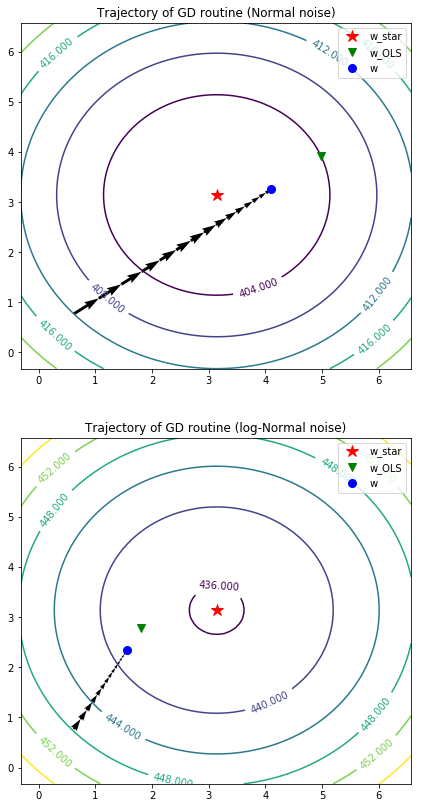

In [26]:
import matplotlib
import matplotlib.pyplot as plt

# Visualize the output (in 2D case).
mypath = al.wstore

if (d == 2):
    
    myfig = plt.figure(figsize=(7,14))
    
    # Prep for contour lines.
    tmpdel = np.linalg.norm(w_star-w_init) * 1
    xvals = np.arange(w_star[0]-tmpdel,w_star[0]+tmpdel, 0.1)
    yvals = np.arange(w_star[1]-tmpdel,w_star[1]+tmpdel, 0.1)
    X, Y = np.meshgrid(xvals, yvals)
    
    # Trajectory for the normal case.
    def risk2D_helper(w1, w2):
        w2D = np.array([w1,w2]).reshape((2,1))
        return risk_norm(w=w2D)
    
    risk2D = np.vectorize(risk2D_helper)
    Z = risk2D(w1=X, w2=Y)
    ax_norm = myfig.add_subplot(2,1,1)
    CS = ax_norm.contour(X, Y, Z)
    ax_norm.quiver(mypath_norm[0,:-1], mypath_norm[1,:-1],
              mypath_norm[0,1:]-mypath_norm[0,:-1],
              mypath_norm[1,1:]-mypath_norm[1,:-1],
              scale_units='xy', angles='xy', scale=1, color='k')
    CS.clabel(inline=1, fontsize=10)
    ax_norm.plot(*w_star, 'r*', markersize=12, label="w_star") # print true value.
    ax_norm.plot(*w_OLS_norm, 'gv', markersize=8, label="w_OLS") # print OLS estimate.
    ax_norm.plot(*mypath_norm[:,-1], 'bo', markersize=8, label="w") # print our final estimate.
    ax_norm.legend(loc=1,ncol=1)
    plt.title('Trajectory of GD routine (Normal noise)')
    
    print("Distance:", np.linalg.norm(mypath_norm[:,-1]-w_star))
    
    # Then log-Normal case.
    def risk2D_helper(w1, w2):
        w2D = np.array([w1,w2]).reshape((2,1))
        return risk_lnorm(w=w2D)
    
    risk2D = np.vectorize(risk2D_helper)
    Z = risk2D(w1=X, w2=Y)

    ax_lnorm = myfig.add_subplot(2,1,2)
    CS = ax_lnorm.contour(X, Y, Z)
    ax_lnorm.quiver(mypath_lnorm[0,:-1], mypath_lnorm[1,:-1],
              mypath_lnorm[0,1:]-mypath_lnorm[0,:-1],
              mypath_lnorm[1,1:]-mypath_lnorm[1,:-1],
              scale_units='xy', angles='xy', scale=1, color='k')
    CS.clabel(inline=1, fontsize=10)
    ax_lnorm.plot(*w_star, 'r*', markersize=12, label="w_star") # print true value.
    ax_lnorm.plot(*w_OLS_lnorm, 'gv', markersize=8, label="w_OLS") # print OLS estimate.
    ax_lnorm.plot(*mypath_lnorm[:,-1], 'bo', markersize=8, label="w") # print our final estimate.
    ax_lnorm.legend(loc=1,ncol=1)
    plt.title('Trajectory of GD routine (log-Normal noise)')
    
    print("Distance:", np.linalg.norm(mypath_lnorm[:,-1]-w_star))
    
    plt.show()
    
    

In this way, we see how there is some unseen "true" objective function (here $R$, computed by `risk`) underlying the learning algorithm, which carries out optimization of a quantity that approximates this true risk. In the case of gradient descent, ideally we would like to use the gradient of the risk $\nabla R(w_{(t)})$ at each step, but since this is unobservable, we settle for the empirical mean of $\nabla L(w;z)$.

__Exercises:__

0. With contours of the "true" objective, namely the risk now available, once again try modifying the parameters controlling the underlying distribution and the algorithm.

0. Using concepts such as "generalization" and "overfitting", describe the phenomena that are observed.

___